# Evaluate the classifier's transferability on a tiled dataset from Bern cohorts

In [4]:
import importlib
import os
import functools

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import seaborn as sns

import Abed_utils

## Load and build model

In [5]:
patch_size = 8
batch_size = 8
im_size = 224
path_to_backbone = './ckpts/dino_deitsmall8_pretrain.pth'
path_to_classifier = './ckpts/classifier_K19_CE_100ep_200_100_100_hidden.pt'

transform = functools.partial(Abed_utils.normalize_input, im_size=im_size, patch_size=patch_size)

In [6]:
importlib.reload(Abed_utils)
# backbone = Abed_utils.get_vit(patch_size, path_to_backbone)

# classifier = Abed_utils.ClassificationHead(pretrained_path=path_to_classifier, dropout=0.2, n_hidden=2, hidden_dims=[200,100,100])
features, labels = Abed_utils.load_features(os.path.join(Abed_utils.OUTPUT_ROOT, 'features'), cuda=True)
classifier = Abed_utils.KNNClassifier(features, labels)
# model = nn.Sequential(backbone, classifier)
model = classifier
# model.eval()

tensor([0, 2, 7, 8], device='cuda:0')


100%|██████████| 4006/4006 [00:17<00:00, 224.07it/s]


Predictions [0. 2. 3. 4. 5. 6. 7. 8.]
for 001b_B2005.30530_C_HE.mrxs we get an accuracy of 0.7370 and an f1 of 0.7370


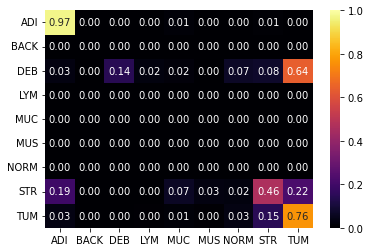

tensor([1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


100%|██████████| 3322/3322 [00:14<00:00, 225.52it/s]


Predictions [0. 1. 2. 3. 4. 5. 6. 7. 8.]
for 352b_B2005.5775_F_HE.mrxs we get an accuracy of 0.6393 and an f1 of 0.6393


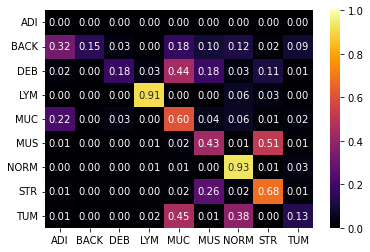

tensor([1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


100%|██████████| 3362/3362 [00:15<00:00, 220.55it/s]


Predictions [0. 1. 2. 3. 4. 5. 6. 7. 8.]
for 565c_B2012.15587_B_HE.mrxs we get an accuracy of 0.5932 and an f1 of 0.5932


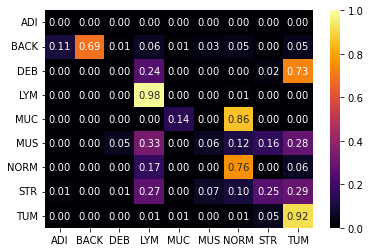

In [18]:
if Abed_utils.BERN_TILES_ROOT is None:
    raise RuntimeError('labelled Bern tiles not available on this machine, run on the dataserver')

wsis = os.listdir(Abed_utils.BERN_TILES_ROOT)
with torch.no_grad():
    for wsi in wsis:

        # ds = ImageFolder(os.path.join(Abed_utils.BERN_TILES_ROOT, wsi), transform=transform)
        features, labels = Abed_utils.load_features(os.path.join(Abed_utils.OUTPUT_ROOT, f'features-{wsi}'), cuda=True)
        # print(torch.unique(labels))
        # break
        ds = TensorDataset(features, labels)
        data = DataLoader(ds, batch_size=batch_size)
        preds = np.empty(len(ds))
        targets = np.empty_like(preds)
        for i, (x, y) in enumerate(tqdm(data)):
            idx = slice(i*batch_size,min((i+1)*batch_size, preds.shape[0]))
            predictions = model(x.cuda()).cpu().numpy()
            preds[idx] = predictions if len(predictions.shape) < 2 else predictions.argmax(axis=1)
            targets[idx] = y.cpu().numpy()
        # print(f'Predictions {np.unique(preds)}')
        acc = (preds == targets).mean()
        f1 = f1_score(targets, preds, average='micro')
        print(f'for {wsi} we get an accuracy of {acc:.4f} and an f1 of {f1:.4f}')
        cmatrix = confusion_matrix(targets, preds, normalize='true')
        for i in range(9):
            if i not in preds and i not in targets:
                cmatrix = np.insert(cmatrix, i, np.zeros(cmatrix.shape[1]), 0)
                cmatrix = np.insert(cmatrix, i, np.zeros(cmatrix.shape[0]), 1)
        sns.heatmap(cmatrix, cmap='inferno', annot=True, fmt='.2f', vmin=0, vmax=1,
                    xticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'],
                    yticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])
        plt.show()

